# Overwatch Analysis

## Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from pandas import Series
from datetime import datetime

pd.options.mode.chained_assignment = None

## Descriptive Analysis

### Clean Data

In [2]:
#Load data
overwatch = pd.read_csv('data.csv')

#View columns
overwatch.columns

Index(['Season', 'Date', 'Day of the Week', 'Queue Type', 'Voice', 'Music',
       'SR Before', 'SR After', 'W/L/D', 'Map', 'Hero 1', 'Hero 2', 'Hero 3',
       'Hero 4', 'Hero 5', 'Prior Outcome', 'Game of the Day',
       'Number of Heroes', 'Doomfist', 'Genji', 'McCree', 'Pharah', 'Reaper',
       'Soldier 76', 'Sombra', 'Tracer', 'Bastion', 'Hanzo', 'Junkrat', 'Mei',
       'Torbjorn', 'Widowmaker', 'DVa', 'Orisa', 'Reinhardt', 'Roadhog',
       'Winston', 'Zarya', 'Ana', 'Lucio', 'Mercy', 'Moira', 'Symmetra',
       'Zenyatta'],
      dtype='object')

In [3]:
#Hero 1-5 is unnecessary since we have boolean representations in later attributes
overwatch = overwatch.drop(['Hero 1','Hero 2','Hero 3','Hero 4','Hero 5'], axis=1)

#We are interested in what factors into a win. Remove matches that resulted in a draw
overwatch = overwatch[overwatch['W/L/D'] != 'Draw']

In [4]:
#Remove columns for unused/rarely used heroes (at least 10 games to include)
heroes_count = overwatch.iloc[:,13:39].sum()
heroes_count.index

exclude_heroes = list(heroes_count[heroes_count < 10].index)
include_heroes = list(heroes_count[heroes_count >= 10].index)
overwatch = overwatch.drop(exclude_heroes, axis=1)

In [5]:
#Convert Date to datetime
overwatch['Date'] = pd.to_datetime(overwatch['Date'])

### Skill Rating Over Time

In [6]:
#Create SR column which uses 'SR After' unless it is a placement. 
overwatch['SR'] = pd.to_numeric(overwatch['SR After'], errors='coerce')

#Use forward propogation to fill SR NANs with last value of SR
overwatch['SR'] = overwatch['SR'].fillna(method='ffill')

In [7]:
#Create aggregated average by day
average_SR_day = overwatch.groupby(['Date'])['SR'].mean()

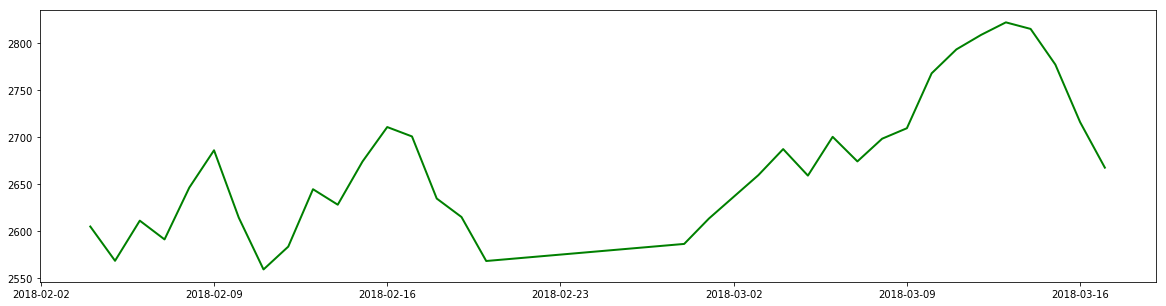

In [8]:
#Plot average SR by day
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(average_SR_day.index, average_SR_day, color="green", linewidth=2, label="Average SR Trending")
plt.show()

In [9]:
#Remove SR Before/After and any matches that resulted in a draw
overwatch = overwatch.drop(['SR Before','SR After'], axis=1)

#Define response as binary Win variable
overwatch['win'] = 0
overwatch['win'][overwatch['W/L/D']=='Win'] = 1

### Win Rate by Game of the Day

In [10]:
#Find win rate by the number of games played each day
winrate_by_game_of_the_day = overwatch.groupby(['Game of the Day'])['win'].mean()

In [11]:
winrate_by_game_of_the_day

Game of the Day
1     0.363636
2     0.470588
3     0.666667
4     0.500000
5     0.384615
6     0.500000
7     0.375000
8     0.666667
9     0.750000
10    0.500000
Name: win, dtype: float64

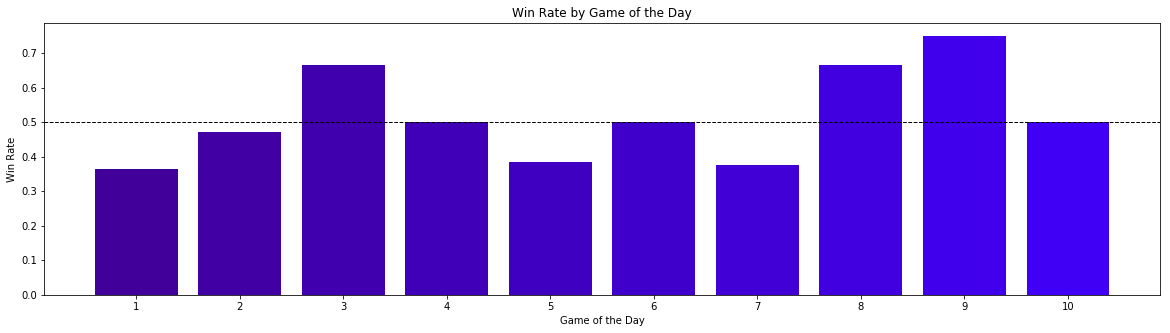

In [12]:
#Plot winrate by game of the day
my_colors = [(0.25, 0, 0.6 + x/25.0) for x in range(len(winrate_by_game_of_the_day))]

fig1 = plt.figure(figsize=(20,5))

ax1 = fig1.add_subplot(111)
ax1.bar(winrate_by_game_of_the_day.index, winrate_by_game_of_the_day, color=my_colors)
ax1.axhline(y=0.5, color="black", linestyle="--", linewidth=1)
ax1.set_xticks(winrate_by_game_of_the_day.index)

plt.title("Win Rate by Game of the Day")
plt.xlabel("Game of the Day")
plt.ylabel("Win Rate")

plt.show()

### Win Rate by Hero Count

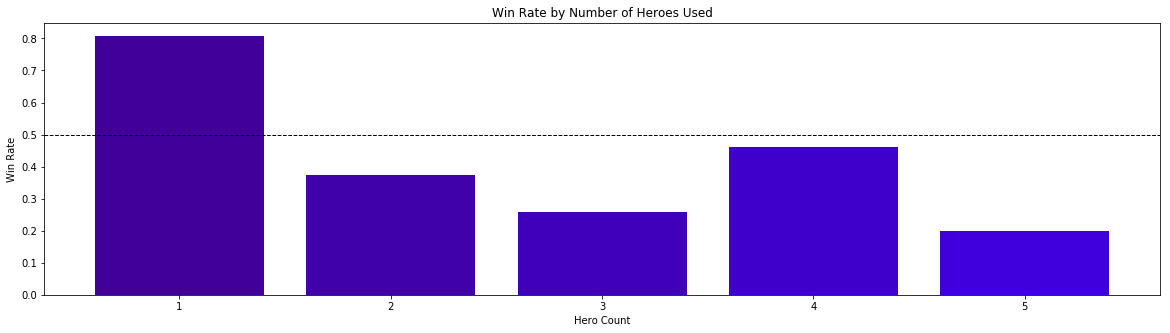

In [13]:
#Look at win rate by number of heroes used
winrate_by_hero_count = overwatch.groupby(['Number of Heroes'])['win'].mean()

#Plot winrate by number of heroes
my_colors = [(0.25, 0, 0.6 + x/15.0) for x in range(len(winrate_by_hero_count))]

fig2 = plt.figure(figsize=(20,5))

ax2 = fig2.add_subplot(111)
ax2.bar(winrate_by_hero_count.index, winrate_by_hero_count, color=my_colors)
ax2.axhline(y=0.5, color="black", linestyle="--", linewidth=1)

plt.title("Win Rate by Number of Heroes Used")
plt.ylabel("Win Rate")
plt.xlabel("Hero Count")

plt.show()

### Win Rate by Map

In [14]:
winrate_by_map = overwatch.groupby(['Map'])['win'].mean()
map_dat = {'MapName': winrate_by_map.index, 'WinRate' : winrate_by_map}
map_df = pd.DataFrame(data=map_dat)
map_df_sorted = map_df.sort_values(by='WinRate', axis=0, ascending=False)
map_df_sorted.index = pd.Series(range(1,len(map_df_sorted)+1))

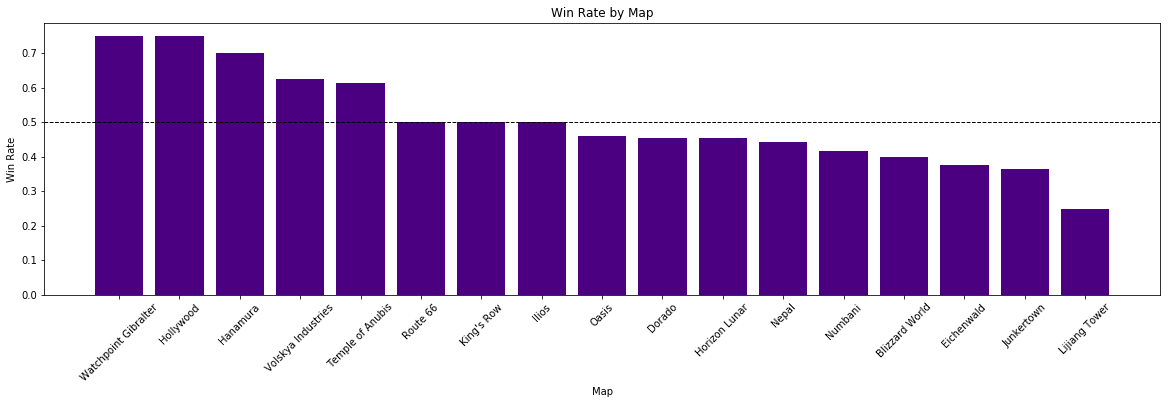

In [15]:
fig3 = plt.figure(figsize=(20,5))

ax3 = fig3.add_subplot(111)
ax3.bar(map_df_sorted.index, map_df_sorted['WinRate'], color='indigo')
ax3.axhline(y=0.5, color="black", linestyle="--", linewidth=1)
ax3.set_xticks(map_df_sorted.index)
ax3.set_xticklabels(list(map_df_sorted['MapName']))

plt.title("Win Rate by Map")
plt.xlabel("Map")
plt.ylabel("Win Rate")

plt.xticks(rotation=45)

plt.show()

## Feature Engineering

### Single vs. Multiple Heroes

In [16]:
#The barplot of win rate by number of heroes used suggests single-hero vs. multiple-heroes used is important. Simplify this feature to binary
overwatch['Single Hero'] =  0
overwatch['Single Hero'][overwatch['Number of Heroes']==1] = 1

### Map Type

In [17]:
#Reduce number of maps by grouping them by map type
overwatch['Map Type'] = 'None'

#Assault Maps
overwatch['Map Type'][overwatch['Map']=='Hanamura'] = 'Assault'
overwatch['Map Type'][overwatch['Map']=='Horizon Lunar'] = 'Assault'
overwatch['Map Type'][overwatch['Map']=='Temple of Anubis'] = 'Assault'
overwatch['Map Type'][overwatch['Map']=='Volskya Industries'] = 'Assault'

#Control Maps
overwatch['Map Type'][overwatch['Map']=='Oasis'] = 'Control'
overwatch['Map Type'][overwatch['Map']=='Nepal'] = 'Control'
overwatch['Map Type'][overwatch['Map']=='Ilios'] = 'Control'
overwatch['Map Type'][overwatch['Map']=='Lijiang Tower'] = 'Control'

#Escort Maps
overwatch['Map Type'][overwatch['Map']=='Watchpoint Gibralter'] = 'Escort'
overwatch['Map Type'][overwatch['Map']=='Junkertown'] = 'Escort'
overwatch['Map Type'][overwatch['Map']=='Route 66'] = 'Escort'
overwatch['Map Type'][overwatch['Map']=='Dorado'] = 'Escort'

#Hybrid Maps
overwatch['Map Type'][overwatch['Map']=='Eichenwald'] = 'Hybrid'
overwatch['Map Type'][overwatch['Map']=="King's Row"] = 'Hybrid'
overwatch['Map Type'][overwatch['Map']=='Numbani'] = 'Hybrid'
overwatch['Map Type'][overwatch['Map']=='Hollywood'] = 'Hybrid'
overwatch['Map Type'][overwatch['Map']=='Blizzard World'] = 'Hybrid'

### Weighted Hero Use

In [18]:
#Look at win rate by each hero (weighted by how many heroes used)
overwatch_heroes_weighted = overwatch.loc[:,'McCree':'Moira'].div(overwatch['Number of Heroes'], axis=0)

wins = np.array(overwatch['win'])
wins_arr = np.array([wins])
heroes = np.array(overwatch_heroes_weighted)
hero_win_count = np.dot(wins_arr,heroes).transpose()
hero_used_count = np.array([np.sum(heroes,axis=0)]).transpose()
hero_win_rate = (hero_win_count/hero_used_count)
include_heroes_arr = np.array([include_heroes]).transpose()

In [19]:
heroes_arr = map(lambda x: x[0], include_heroes_arr)
heroes_used = pd.Series(heroes_arr)
win_rate_arr = map(lambda x: x[0], hero_win_rate)
heroes_win_rate = pd.Series(win_rate_arr)
heroes_dat = {'Hero' : heroes_used,'WinRate' : heroes_win_rate}
heroes_df = pd.DataFrame(data=heroes_dat)
heroes_df_sorted = heroes_df.sort_values(by='WinRate', axis=0, ascending=False)
heroes_df_sorted.index = pd.Series(range(1,len(heroes_df_sorted)+1))

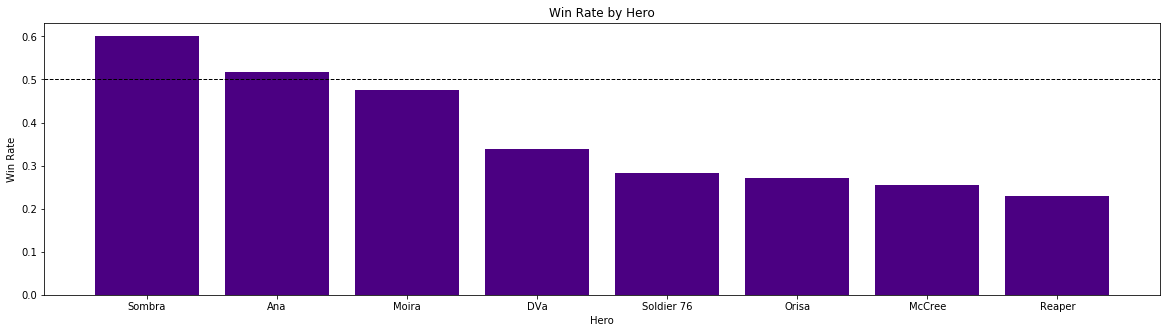

In [20]:
fig4 = plt.figure(figsize=(20,5))

ax4 = fig4.add_subplot(111)
ax4.bar(heroes_df_sorted.index, heroes_df_sorted['WinRate'], color='indigo')
ax4.axhline(y=0.5, color="black", linestyle="--", linewidth=1)
ax4.set_xticks(heroes_df_sorted.index)
ax4.set_xticklabels(list(heroes_df_sorted['Hero']))

plt.title("Win Rate by Hero")
plt.xlabel("Hero")
plt.ylabel("Win Rate")

plt.show()

## Modeling

### Random Forest Classifier

In [21]:
#Replace hero indicators with weighted hero use
overwatch.loc[:,'McCree':'Moira'] = overwatch_heroes_weighted
overwatch = overwatch.drop(['W/L/D','SR', 'Number of Heroes', 'Map'], axis=1)

#Change all features to dummy variables
overwatch['Month'] = overwatch['Date'].dt.month
overwatch['Day'] = overwatch['Date'].dt.day
overwatch = overwatch.drop(['Date'], axis=1)
overwatch_processed = pd.get_dummies(overwatch)

In [22]:
#Create labels (binary Win variable) as value we want to predict
labels = np.array(overwatch_processed['win'])

#Remove labels from features
features = overwatch_processed.drop(['win'], axis=1)

#Save feature names for later use
feature_list = list(features.columns)

#Convert to array
features = np.array(features)

In [23]:
#Split data into train/test splits
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state=815)

In [24]:
#Establish Baseline

#Use average of training set's 'win' to create a random binomial prediction with p=mean(win)
average_train_wins = train_labels.mean()
n_test = test_features.shape[0]
baseline_preds = np.random.binomial(1, average_train_wins, n_test)

#Use F1 score to measure model performance i.e., F1 = 2 * (precision * recall) / (precision + recall)
baseline_f1_score = f1_score(test_labels, baseline_preds)
baseline_f1_score

0.22857142857142856

In [25]:
#Initiate Random Forest model which uses 10,000 trees
rf = RandomForestClassifier(n_estimators=10000, max_depth=5)

#Train model with training data
rf.fit(train_features, train_labels);

#Predict with test set
rf_preds = rf.predict(test_features)

#Find Random Forest F1 score
rf_f1_score = f1_score(test_labels, rf_preds)
rf_f1_score

0.5945945945945946

In [26]:
#List importance of each variable within the random forest
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
sorted_feature_importances_df = pd.DataFrame(sorted(feature_importances, key = lambda x:x[1], reverse=True))
sorted_feature_importances_df.columns = ['Variable','Importance']
sorted_feature_importances_df

,Variable,Importance
0,Single Hero,0.14
1,Sombra,0.13
2,Day,0.09
3,Game of the Day,0.07
4,Map Type_Assault,0.04
5,McCree,0.03
6,Orisa,0.03
7,Ana,0.03
8,Moira,0.03
9,Day of the Week_Wed,0.03
